# Description
The following analysis was made using the last seven years of third Friday enrollment data.

I am a software engineer and I used this background to compile the data and present analysis from it. **I am not a statistician.**

# Compiling the Initial Dataset
The third Friday counts were provided as a PDF. I manually entered that data into a spreadsheet, then extracted the data, and reshaped it to long-form for further analysis.

In [1]:
from pyexcel_ods3 import get_data
import numpy as np
import pandas as pd
from IPython.display import display, Markdown, Latex
from matplotlib import pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from numbers import Number


def as_percent(v, precision='0.2'):
    """Convert number to percentage string."""
    if isinstance(v, Number):
        return "{{:{}%}}".format(precision).format(v)
    else:
        raise TypeError("Numeric type required")

        
def as_year_interval(v):
    return pd.DateOffset(years=v)


register_matplotlib_converters()
pd.options.display.max_rows = 14

df = pd.DataFrame()
for date, rows in get_data("Third Friday.ods").items():
    ydf = pd.DataFrame(rows[1:], columns=rows[0])
    ydf['Date'] = pd.to_datetime(date)
    ydf = ydf.replace(r'^\s*$', np.NaN, regex=True)
    ydf['School'] = ydf['School'].fillna(method='ffill')
    ydf = pd.melt(ydf, id_vars=['Date', 'School'], var_name='Grade', value_name='Students')
    ydf = ydf[ydf['Students'].notnull()]

    df = df.append(ydf)

df['Students'] = df['Students'].astype('int')
df['School Year'] = pd.Categorical(df['Date'].apply(lambda x: "{} / {}".format(x.strftime('%Y'), int(x.strftime('%Y')) + 1)), ordered=True)
df['Grade'] = pd.Categorical(df['Grade'], ['Grade K', 'Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'])

# df['Cohort Group'] = df['School Year'].cat.codes - df['Grade'].cat.codes
df['Cohort Group'] = (df['Date'].dt.strftime('%Y').astype('int') - df['Grade'].cat.codes).apply(lambda x: "{} / {}".format(x, x + 1))

display(df.set_index(['School Year','School','Grade'])[['Students']])

Students
School Year School    Grade            
2019 / 2020 Davey     Grade K        20
                      Grade K        18
                      Grade K        19
            Flynn     Grade K        11
                      Grade K        12
...                                 ...
2013 / 2014 Roosevelt Grade 5        20
                      Grade 5        21
            Sherman   Grade 5        23
                      Grade 5        22
                      Grade 5        23

[1489 rows x 1 columns]

# School Classrooms Analysis
The most basic analysis we can do is comparing the number of classrooms in use at a school to the schools stated section size.

*Available Classrooms is calculated as `6 * school sections`.*

In [2]:
classrooms_per_school_year = df[['School Year','School','Students']].groupby(['School Year','School']).count().rename(columns={'Students':'Classrooms in Use'})

cdf = pd.DataFrame([('Davey', 18),('Flynn', 12),('Lakeshore', 18),('Locust Lane', 18),('Longfellow', 18),('Manz', 18),('Meadowview', 18),('Northwoods', 18),('Putnam Heights', 18),('Robbins', 24),('Roosevelt',12),('Sherman',24)], columns=['School','Available Classrooms'])
classroom_utilization_per_school_year = classrooms_per_school_year.reset_index().merge(cdf)

for schoolName, school_classroom_utilization_per_year in classroom_utilization_per_school_year.groupby(['School']):
    display(Markdown(f'## {schoolName}'))
    display(school_classroom_utilization_per_year.set_index(['School Year']).sort_values('School Year', ascending=False)[['Classrooms in Use', 'Available Classrooms']])

## Davey

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,15,18
2018 / 2019,15,18
2017 / 2018,16,18
2016 / 2017,17,18
2015 / 2016,17,18
2014 / 2015,17,18
2013 / 2014,18,18


## Flynn

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,14,12
2018 / 2019,14,12
2017 / 2018,14,12
2016 / 2017,15,12
2015 / 2016,16,12
2014 / 2015,16,12
2013 / 2014,15,12


## Lakeshore

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,21,18
2018 / 2019,20,18
2017 / 2018,19,18
2016 / 2017,21,18
2015 / 2016,23,18
2014 / 2015,23,18
2013 / 2014,23,18


## Locust Lane

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,15,18
2018 / 2019,14,18
2017 / 2018,13,18
2016 / 2017,13,18
2015 / 2016,16,18
2014 / 2015,16,18
2013 / 2014,16,18


## Longfellow

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,15,18
2018 / 2019,14,18
2017 / 2018,14,18
2016 / 2017,14,18
2015 / 2016,16,18
2014 / 2015,16,18
2013 / 2014,17,18


## Manz

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,18,18
2018 / 2019,21,18
2017 / 2018,20,18
2016 / 2017,19,18
2015 / 2016,18,18
2014 / 2015,17,18
2013 / 2014,17,18


## Meadowview

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,19,18
2018 / 2019,20,18
2017 / 2018,20,18
2016 / 2017,20,18
2015 / 2016,19,18
2014 / 2015,18,18
2013 / 2014,18,18


## Northwoods

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,17,18
2018 / 2019,18,18
2017 / 2018,18,18
2016 / 2017,18,18
2015 / 2016,18,18
2014 / 2015,17,18
2013 / 2014,17,18


## Putnam Heights

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,18,18
2018 / 2019,18,18
2017 / 2018,18,18
2016 / 2017,18,18
2015 / 2016,17,18
2014 / 2015,17,18
2013 / 2014,18,18


## Robbins

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,23,24
2018 / 2019,21,24
2017 / 2018,22,24
2016 / 2017,22,24
2015 / 2016,20,24
2014 / 2015,21,24
2013 / 2014,24,24


## Roosevelt

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,12,12
2018 / 2019,12,12
2017 / 2018,12,12
2016 / 2017,13,12
2015 / 2016,14,12
2014 / 2015,15,12
2013 / 2014,13,12


## Sherman

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,22,24
2018 / 2019,20,24
2017 / 2018,21,24
2016 / 2017,22,24
2015 / 2016,23,24
2014 / 2015,24,24
2013 / 2014,24,24


We cannot compare two schools classroom usage unless they have the same scale. We can apply a uniform scale to the data by taking `the number of classrooms in use / number of available classrooms`.

*Editorial decision: I have selected a center of 100% for the heatmap color gradient.*

School,Davey,Flynn,Lakeshore,Locust Lane,Longfellow,Manz,Meadowview,Northwoods,Putnam Heights,Robbins,Roosevelt,Sherman
School Year,,,,,,,,,,,,
2019 / 2020,83.33%,116.67%,116.67%,83.33%,83.33%,100.00%,105.56%,94.44%,100.00%,95.83%,100.00%,91.67%
2018 / 2019,83.33%,116.67%,111.11%,77.78%,77.78%,116.67%,111.11%,100.00%,100.00%,87.50%,100.00%,83.33%
2017 / 2018,88.89%,116.67%,105.56%,72.22%,77.78%,111.11%,111.11%,100.00%,100.00%,91.67%,100.00%,87.50%
2016 / 2017,94.44%,125.00%,116.67%,72.22%,77.78%,105.56%,111.11%,100.00%,100.00%,91.67%,108.33%,91.67%
2015 / 2016,94.44%,133.33%,127.78%,88.89%,88.89%,100.00%,105.56%,100.00%,94.44%,83.33%,116.67%,95.83%
2014 / 2015,94.44%,133.33%,127.78%,88.89%,88.89%,94.44%,100.00%,94.44%,94.44%,87.50%,125.00%,100.00%
2013 / 2014,100.00%,125.00%,127.78%,88.89%,94.44%,94.44%,100.00%,94.44%,100.00%,100.00%,108.33%,100.00%


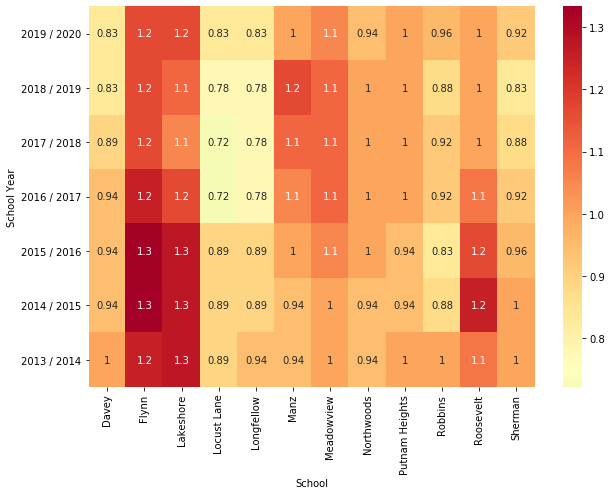

\pagebreak

In [3]:
classroom_utilization_per_school_year['Classroom Utilization Ratio'] = (classroom_utilization_per_school_year['Classrooms in Use'] / classroom_utilization_per_school_year['Available Classrooms'])
classroom_utilization_per_school_year['Classroom Utilization Percent'] = classroom_utilization_per_school_year['Classroom Utilization Ratio'].apply(as_percent)

display(classroom_utilization_per_school_year[['School Year','School','Classroom Utilization Percent']].set_index(['School Year','School']).unstack()['Classroom Utilization Percent'].sort_values('School Year', ascending=False))

classroom_utilization_per_school_year = classroom_utilization_per_school_year[['School Year','School','Classroom Utilization Ratio']].set_index(['School Year','School']).unstack()['Classroom Utilization Ratio'].sort_values('School Year', ascending=False)

fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(classroom_utilization_per_school_year, center=.75, annot=True, cmap="RdYlGn_r", ax=ax)

plt.yticks(rotation=0)
plt.show()
display(Markdown('\pagebreak'))

# Per-Grade Capacity Analysis
The school classroom analysis is a step-wise measurement -- the ratio will not change until a new classroom is allocated. It does not indicate how close a school is to needing to allocate a new classroom.

If we take the `number of students in a grade / (maximum number of students per classroom * sections at school)`, it's possible to get insight into how close a grade at a school is to needing a new classroom.

*Editorial decision: I have selected a center of 75% for the heatmap color gradient.*

\pagebreak

## Davey

Grade,Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5
School Year,,,,,,
2019 / 2020,76.00%,80.00%,66.67%,89.33%,56.32%,63.22%
2018 / 2019,78.67%,66.67%,90.67%,62.67%,67.82%,80.46%
2017 / 2018,62.67%,82.67%,61.33%,73.33%,83.91%,67.82%
2016 / 2017,81.33%,54.67%,73.33%,89.33%,68.97%,82.76%
2015 / 2016,54.67%,81.33%,85.33%,76.00%,77.01%,85.06%
2014 / 2015,78.67%,89.33%,73.33%,88.00%,87.36%,62.07%
2013 / 2014,90.67%,81.33%,88.00%,102.67%,58.62%,72.41%


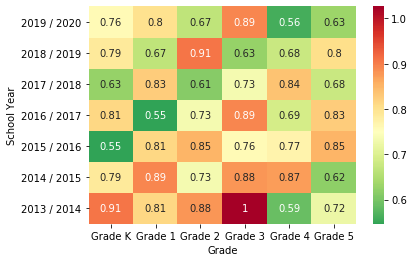

\pagebreak

## Flynn

Grade,Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5
School Year,,,,,,
2019 / 2020,72.00%,108.00%,74.00%,60.00%,77.59%,84.48%
2018 / 2019,120.00%,78.00%,70.00%,98.00%,86.21%,82.76%
2017 / 2018,82.00%,74.00%,106.00%,92.00%,87.93%,98.28%
2016 / 2017,90.00%,104.00%,106.00%,110.00%,100.00%,87.93%
2015 / 2016,102.00%,108.00%,112.00%,116.00%,86.21%,63.79%
2014 / 2015,108.00%,108.00%,108.00%,96.00%,72.41%,77.59%
2013 / 2014,110.00%,108.00%,114.00%,80.00%,84.48%,84.48%


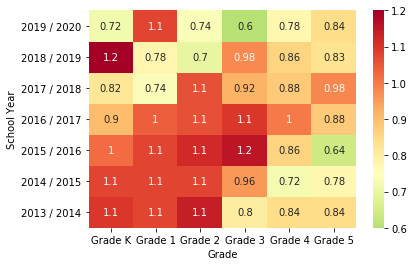

\pagebreak

## Lakeshore

Grade,Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5
School Year,,,,,,
2019 / 2020,82.67%,101.33%,97.33%,88.00%,70.11%,72.41%
2018 / 2019,102.67%,105.33%,84.00%,92.00%,70.11%,87.36%
2017 / 2018,102.67%,96.00%,97.33%,81.33%,88.51%,96.55%
2016 / 2017,92.00%,97.33%,78.67%,108.00%,95.40%,77.01%
2015 / 2016,98.67%,86.67%,109.33%,100.00%,78.16%,86.21%
2014 / 2015,100.00%,106.67%,101.33%,96.00%,85.06%,66.67%
2013 / 2014,102.67%,106.67%,89.33%,101.33%,72.41%,82.76%


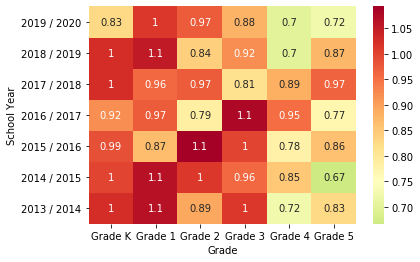

\pagebreak

## Locust Lane

Grade,Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5
School Year,,,,,,
2019 / 2020,62.67%,61.33%,46.67%,53.33%,45.98%,44.83%
2018 / 2019,60.00%,52.00%,53.33%,56.00%,44.83%,51.72%
2017 / 2018,65.33%,54.67%,53.33%,57.33%,54.02%,52.87%
2016 / 2017,61.33%,54.67%,50.67%,72.00%,52.87%,51.72%
2015 / 2016,60.00%,54.67%,68.00%,58.67%,50.57%,43.68%
2014 / 2015,58.67%,72.00%,58.67%,61.33%,51.72%,56.32%
2013 / 2014,68.00%,58.67%,64.00%,65.33%,51.72%,59.77%


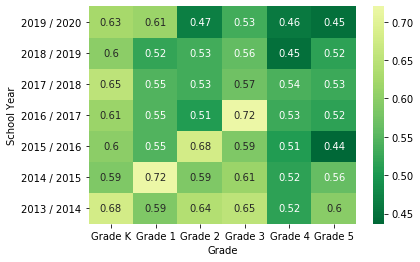

\pagebreak

## Longfellow

Grade,Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5
School Year,,,,,,
2019 / 2020,81.33%,61.33%,58.67%,58.67%,52.87%,45.98%
2018 / 2019,61.33%,58.67%,65.33%,58.67%,42.53%,48.28%
2017 / 2018,60.00%,65.33%,57.33%,52.00%,45.98%,55.17%
2016 / 2017,62.67%,54.67%,53.33%,42.67%,51.72%,48.28%
2015 / 2016,64.00%,60.00%,56.00%,65.33%,52.87%,47.13%
2014 / 2015,64.00%,61.33%,62.67%,60.00%,51.72%,64.37%
2013 / 2014,70.67%,81.33%,65.33%,58.67%,58.62%,37.93%


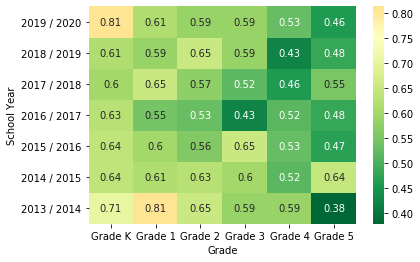

\pagebreak

## Manz

Grade,Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5
School Year,,,,,,
2019 / 2020,101.33%,76.00%,102.67%,85.33%,96.55%,64.37%
2018 / 2019,84.00%,108.00%,112.00%,112.00%,67.82%,90.80%
2017 / 2018,109.33%,97.33%,112.00%,92.00%,89.66%,70.11%
2016 / 2017,93.33%,112.00%,89.33%,104.00%,75.86%,70.11%
2015 / 2016,110.67%,90.67%,100.00%,82.67%,70.11%,60.92%
2014 / 2015,86.67%,97.33%,84.00%,92.00%,66.67%,80.46%
2013 / 2014,97.33%,84.00%,93.33%,85.33%,86.21%,65.52%


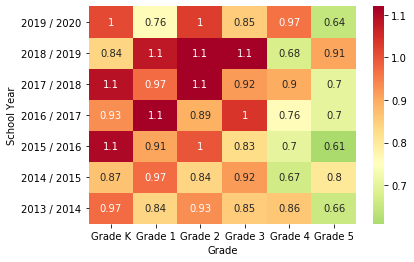

\pagebreak

## Meadowview

Grade,Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5
School Year,,,,,,
2019 / 2020,90.67%,82.67%,106.67%,110.67%,87.36%,95.40%
2018 / 2019,86.67%,96.00%,112.00%,112.00%,86.21%,85.06%
2017 / 2018,94.67%,94.67%,105.33%,101.33%,90.80%,81.61%
2016 / 2017,89.33%,100.00%,108.00%,104.00%,90.80%,100.00%
2015 / 2016,86.67%,109.33%,106.67%,93.33%,89.66%,83.91%
2014 / 2015,105.33%,90.67%,94.67%,92.00%,75.86%,66.67%
2013 / 2014,93.33%,104.00%,94.67%,88.00%,65.52%,94.25%


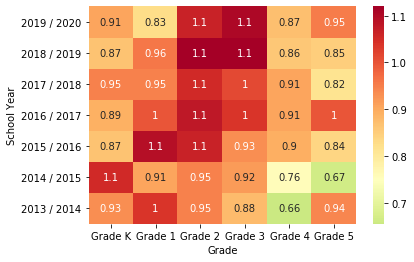

\pagebreak

## Northwoods

Grade,Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5
School Year,,,,,,
2019 / 2020,85.33%,81.33%,82.67%,78.67%,58.62%,64.37%
2018 / 2019,84.00%,85.33%,73.33%,73.33%,64.37%,83.91%
2017 / 2018,80.00%,81.33%,70.67%,77.33%,85.06%,82.76%
2016 / 2017,97.33%,73.33%,80.00%,96.00%,77.01%,72.41%
2015 / 2016,70.67%,85.33%,89.33%,94.67%,74.71%,67.82%
2014 / 2015,82.67%,88.00%,97.33%,85.33%,70.11%,55.17%
2013 / 2014,96.00%,106.67%,81.33%,88.00%,63.22%,63.22%


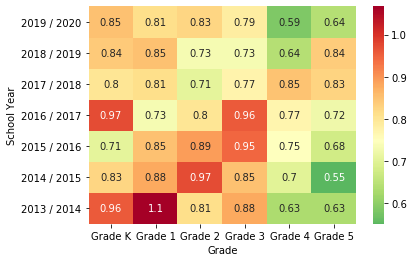

\pagebreak

## Putnam Heights

Grade,Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5
School Year,,,,,,
2019 / 2020,93.33%,96.00%,92.00%,92.00%,90.80%,80.46%
2018 / 2019,96.00%,89.33%,94.67%,94.67%,77.01%,91.95%
2017 / 2018,77.33%,94.67%,88.00%,88.00%,94.25%,90.80%
2016 / 2017,92.00%,94.67%,70.67%,100.00%,78.16%,83.91%
2015 / 2016,96.00%,68.00%,101.33%,97.33%,73.56%,70.11%
2014 / 2015,58.67%,94.67%,84.00%,78.67%,70.11%,72.41%
2013 / 2014,85.33%,73.33%,69.33%,74.67%,68.97%,74.71%


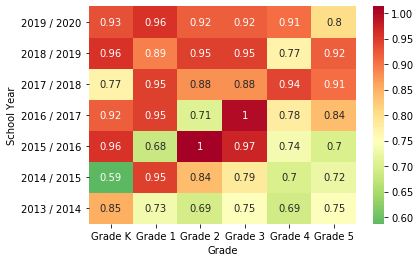

\pagebreak

## Robbins

Grade,Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5
School Year,,,,,,
2019 / 2020,82.00%,89.00%,89.00%,89.00%,65.52%,74.14%
2018 / 2019,87.00%,75.00%,74.00%,74.00%,78.45%,81.90%
2017 / 2018,74.00%,89.00%,68.00%,94.00%,79.31%,81.03%
2016 / 2017,84.00%,62.00%,84.00%,89.00%,75.86%,66.38%
2015 / 2016,69.00%,77.00%,90.00%,96.00%,66.38%,74.14%
2014 / 2015,74.00%,87.00%,94.00%,75.00%,75.00%,84.48%
2013 / 2014,82.00%,85.00%,76.00%,75.00%,81.90%,85.34%


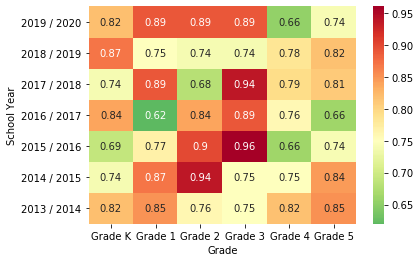

\pagebreak

## Roosevelt

Grade,Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5
School Year,,,,,,
2019 / 2020,98.00%,104.00%,86.00%,96.00%,67.24%,77.59%
2018 / 2019,96.00%,90.00%,88.00%,88.00%,82.76%,91.38%
2017 / 2018,88.00%,94.00%,92.00%,102.00%,87.93%,91.38%
2016 / 2017,96.00%,92.00%,100.00%,110.00%,93.10%,72.41%
2015 / 2016,102.00%,106.00%,114.00%,122.00%,74.14%,74.14%
2014 / 2015,100.00%,118.00%,110.00%,90.00%,70.69%,89.66%
2013 / 2014,112.00%,96.00%,88.00%,88.00%,86.21%,70.69%


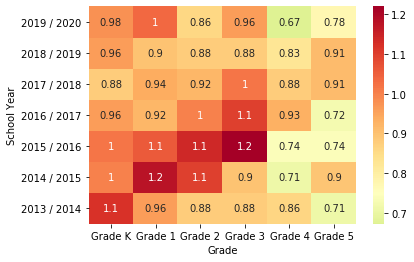

\pagebreak

## Sherman

Grade,Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5
School Year,,,,,,
2019 / 2020,91.00%,86.00%,71.00%,89.00%,62.07%,65.52%
2018 / 2019,79.00%,73.00%,65.00%,65.00%,69.83%,71.55%
2017 / 2018,81.00%,86.00%,67.00%,81.00%,73.28%,62.93%
2016 / 2017,91.00%,70.00%,80.00%,86.00%,68.97%,58.62%
2015 / 2016,78.00%,80.00%,76.00%,83.00%,62.93%,65.52%
2014 / 2015,88.00%,73.00%,90.00%,77.00%,68.97%,56.90%
2013 / 2014,76.00%,84.00%,82.00%,73.00%,56.90%,58.62%


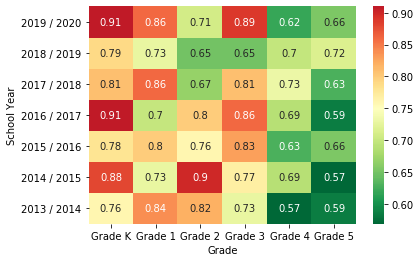

\pagebreak

In [4]:
school_grade_capacity = pd.DataFrame([
    ('Davey','Grade K',75),('Davey','Grade 1',75),('Davey','Grade 2',75),('Davey','Grade 3',75),('Davey','Grade 4',87),('Davey','Grade 5',87),
    ('Flynn','Grade K',50),('Flynn','Grade 1',50),('Flynn','Grade 2',50),('Flynn','Grade 3',50),('Flynn','Grade 4',58),('Flynn','Grade 5',58),
    ('Lakeshore','Grade K',75),('Lakeshore','Grade 1',75),('Lakeshore','Grade 2',75),('Lakeshore','Grade 3',75),('Lakeshore','Grade 4',87),('Lakeshore','Grade 5',87),
    ('Locust Lane','Grade K',75),('Locust Lane','Grade 1',75),('Locust Lane','Grade 2',75),('Locust Lane','Grade 3',75),('Locust Lane','Grade 4',87),('Locust Lane','Grade 5',87),
    ('Longfellow','Grade K',75),('Longfellow','Grade 1',75),('Longfellow','Grade 2',75),('Longfellow','Grade 3',75),('Longfellow','Grade 4',87),('Longfellow','Grade 5',87),
    ('Manz','Grade K',75),('Manz','Grade 1',75),('Manz','Grade 2',75),('Manz','Grade 3',75),('Manz','Grade 4',87),('Manz','Grade 5',87),
    ('Meadowview','Grade K',75),('Meadowview','Grade 1',75),('Meadowview','Grade 2',75),('Meadowview','Grade 3',75),('Meadowview','Grade 4',87),('Meadowview','Grade 5',87),
    ('Northwoods','Grade K',75),('Northwoods','Grade 1',75),('Northwoods','Grade 2',75),('Northwoods','Grade 3',75),('Northwoods','Grade 4',87),('Northwoods','Grade 5',87),
    ('Putnam Heights','Grade K',75),('Putnam Heights','Grade 1',75),('Putnam Heights','Grade 2',75),('Putnam Heights','Grade 3',75),('Putnam Heights','Grade 4',87),('Putnam Heights','Grade 5',87),
    ('Robbins','Grade K',100),('Robbins','Grade 1',100),('Robbins','Grade 2',100),('Robbins','Grade 3',100),('Robbins','Grade 4',116),('Robbins','Grade 5',116),
    ('Roosevelt','Grade K',50),('Roosevelt','Grade 1',50),('Roosevelt','Grade 2',50),('Roosevelt','Grade 3',50),('Roosevelt','Grade 4',58),('Roosevelt','Grade 5',58),
    ('Sherman','Grade K',100),('Sherman','Grade 1',100),('Sherman','Grade 2',100),('Sherman','Grade 3',100),('Sherman','Grade 4',116),('Sherman','Grade 5',116)
], columns=['School','Grade','Maximum Capacity']).reset_index()

students_per_grade = df.groupby(['School Year','School','Grade']).sum().reset_index().merge(school_grade_capacity)
students_per_grade['Grade'] = pd.Categorical(students_per_grade['Grade'], ['Grade K', 'Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'])

del students_per_grade['index']

students_per_grade['Capacity Ratio'] = students_per_grade['Students'] / students_per_grade['Maximum Capacity']
students_per_grade['Capacity Ratio'] = students_per_grade['Capacity Ratio']
students_per_grade['Capacity Percent'] = students_per_grade['Capacity Ratio'].apply(as_percent)

display(Markdown('\pagebreak'))

for school_name, school_capacity_ratio in students_per_grade.groupby(['School']):
    display(Markdown(f'## {school_name}'))
    display(school_capacity_ratio.sort_values('Grade').set_index(['School Year', 'Grade']).unstack().sort_values('School Year', ascending=False)['Capacity Percent'])
    
    ax = sns.heatmap(school_capacity_ratio.sort_values('Grade').set_index(['School Year', 'Grade']).unstack()['Capacity Ratio'], center=.75, annot=True, cmap="RdYlGn_r")
    ax.invert_yaxis()
    plt.show()
    display(Markdown('\pagebreak'))

### Observations
The district classroom size guidelines difference for K-3 and 4-5 are clearly visible in the heatmap.

Schools under stress -- Manz, Meadowview, Putnam Heights, and Roosevelt -- are easily identified by their heatmaps.

Cohort groups are easily identified by their diagnal progression in the heatmap.

# Cohorts
Cohort analysis is frequently used by school districts to make projects.

\pagebreak

## District

### Cohort Total

School Year,2013 / 2014,2014 / 2015,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,,,
2008 / 2009,736,,,,,,
2009 / 2010,717,717,,,,,
2010 / 2011,730,736,716,,,,
2011 / 2012,743,735,736,748,,,
2012 / 2013,793,785,799,794,797,,
2013 / 2014,797,798,816,822,829,818,
2014 / 2015,,742,741,720,739,723,718
2015 / 2016,,,730,711,718,728,718
2016 / 2017,,,,770,759,732,748


\pagebreak

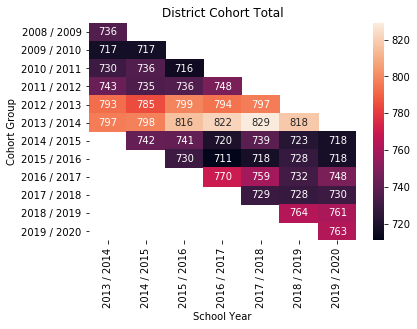

\pagebreak

### Cohort 3 Year Mean

School Year,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,
2010 / 2011,727,,,,
2011 / 2012,738,739,,,
2012 / 2013,792,792,796,,
2013 / 2014,803,812,822,823,
2014 / 2015,,734,733,727,726
2015 / 2016,,,719,719,721
2016 / 2017,,,,753,746
2017 / 2018,,,,,729


\pagebreak

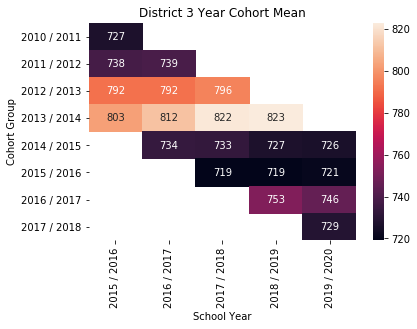

\pagebreak

## Davey

### Cohort Total

School Year,2013 / 2014,2014 / 2015,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,,,
2008 / 2009,63,,,,,,
2009 / 2010,51,54,,,,,
2010 / 2011,77,76,74,,,,
2011 / 2012,66,66,67,72,,,
2012 / 2013,61,55,57,60,59,,
2013 / 2014,68,67,64,67,73,70,
2014 / 2015,,59,61,55,55,59,55
2015 / 2016,,,41,41,46,47,49
2016 / 2017,,,,61,62,68,67


\pagebreak

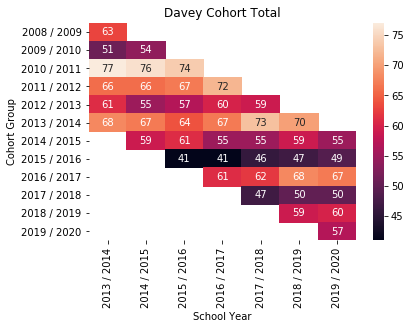

\pagebreak

### Cohort 3 Year Mean

School Year,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,
2010 / 2011,75,,,,
2011 / 2012,66,68,,,
2012 / 2013,57,57,58,,
2013 / 2014,66,66,68,70,
2014 / 2015,,58,57,56,56
2015 / 2016,,,42,44,47
2016 / 2017,,,,63,65
2017 / 2018,,,,,49


\pagebreak

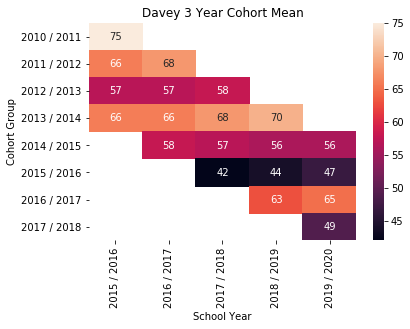

\pagebreak

## Flynn

### Cohort Total

School Year,2013 / 2014,2014 / 2015,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,,,
2008 / 2009,49,,,,,,
2009 / 2010,49,45,,,,,
2010 / 2011,40,42,37,,,,
2011 / 2012,57,48,50,51,,,
2012 / 2013,54,54,58,58,57,,
2013 / 2014,55,54,56,55,51,48,
2014 / 2015,,54,54,53,46,50,49
2015 / 2016,,,51,52,53,49,45
2016 / 2017,,,,45,37,35,30


\pagebreak

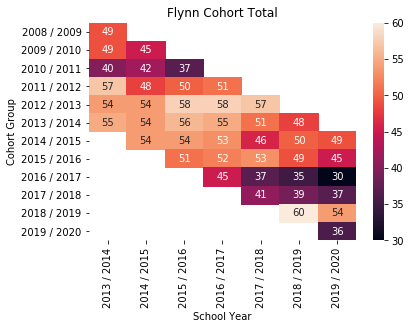

\pagebreak

### Cohort 3 Year Mean

School Year,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,
2010 / 2011,39,,,,
2011 / 2012,51,49,,,
2012 / 2013,55,56,57,,
2013 / 2014,55,55,54,51,
2014 / 2015,,53,51,49,48
2015 / 2016,,,52,51,49
2016 / 2017,,,,39,34
2017 / 2018,,,,,39


\pagebreak

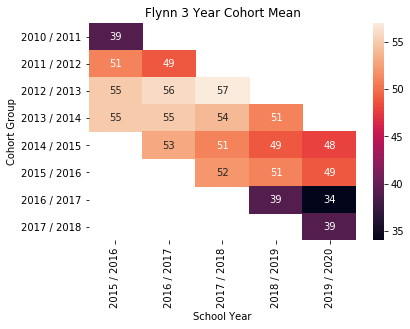

\pagebreak

## Lakeshore

### Cohort Total

School Year,2013 / 2014,2014 / 2015,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,,,
2008 / 2009,72,,,,,,
2009 / 2010,63,58,,,,,
2010 / 2011,76,74,75,,,,
2011 / 2012,67,72,68,67,,,
2012 / 2013,80,76,75,83,84,,
2013 / 2014,77,80,82,81,77,76,
2014 / 2015,,75,65,59,61,61,63
2015 / 2016,,,74,73,73,69,61
2016 / 2017,,,,69,72,63,66


\pagebreak

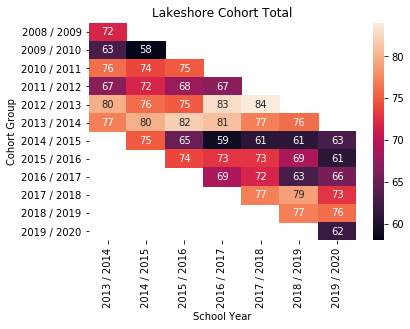

\pagebreak

### Cohort 3 Year Mean

School Year,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,
2010 / 2011,75,,,,
2011 / 2012,69,69,,,
2012 / 2013,77,78,80,,
2013 / 2014,79,81,80,78,
2014 / 2015,,66,61,60,61
2015 / 2016,,,73,71,67
2016 / 2017,,,,68,67
2017 / 2018,,,,,76


\pagebreak

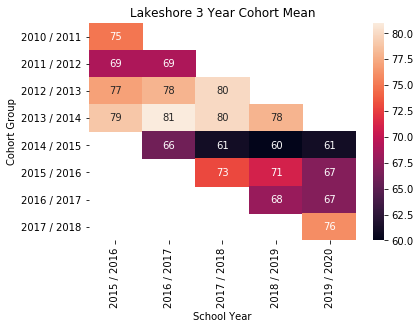

\pagebreak

## Locust Lane

### Cohort Total

School Year,2013 / 2014,2014 / 2015,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,,,
2008 / 2009,52,,,,,,
2009 / 2010,45,49,,,,,
2010 / 2011,49,45,38,,,,
2011 / 2012,48,46,44,45,,,
2012 / 2013,44,44,44,46,46,,
2013 / 2014,51,54,51,54,47,45,
2014 / 2015,,44,41,38,43,39,39
2015 / 2016,,,45,41,40,42,40
2016 / 2017,,,,46,41,40,40


\pagebreak

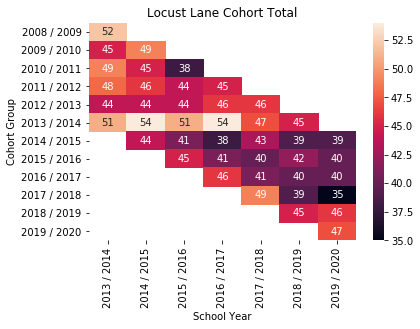

\pagebreak

### Cohort 3 Year Mean

School Year,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,
2010 / 2011,44,,,,
2011 / 2012,46,45,,,
2012 / 2013,44,44,45,,
2013 / 2014,52,53,50,48,
2014 / 2015,,41,40,40,40
2015 / 2016,,,42,41,40
2016 / 2017,,,,42,40
2017 / 2018,,,,,41


\pagebreak

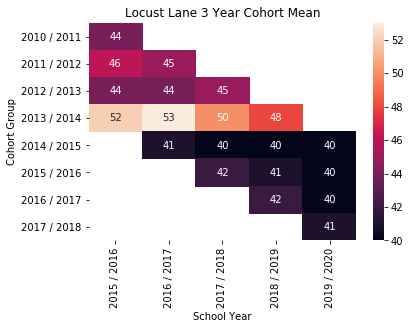

\pagebreak

## Longfellow

### Cohort Total

School Year,2013 / 2014,2014 / 2015,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,,,
2008 / 2009,33,,,,,,
2009 / 2010,51,56,,,,,
2010 / 2011,44,45,41,,,,
2011 / 2012,49,45,46,42,,,
2012 / 2013,61,47,49,45,48,,
2013 / 2014,53,46,42,32,40,42,
2014 / 2015,,48,45,40,39,37,40
2015 / 2016,,,48,41,43,44,46
2016 / 2017,,,,47,49,49,44


\pagebreak

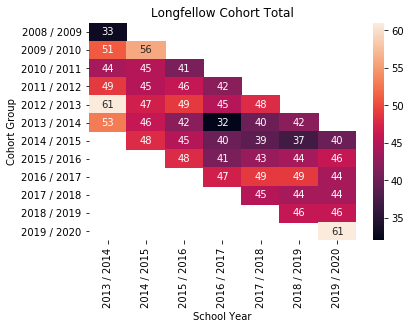

\pagebreak

### Cohort 3 Year Mean

School Year,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,
2010 / 2011,43,,,,
2011 / 2012,46,44,,,
2012 / 2013,52,47,47,,
2013 / 2014,47,40,38,38,
2014 / 2015,,44,41,38,38
2015 / 2016,,,44,42,44
2016 / 2017,,,,48,47
2017 / 2018,,,,,44


\pagebreak

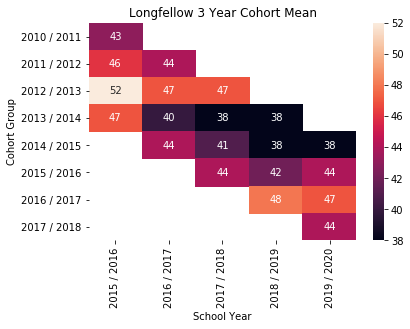

\pagebreak

## Manz

### Cohort Total

School Year,2013 / 2014,2014 / 2015,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,,,
2008 / 2009,57,,,,,,
2009 / 2010,75,70,,,,,
2010 / 2011,64,58,53,,,,
2011 / 2012,70,69,61,61,,,
2012 / 2013,63,63,62,66,61,,
2013 / 2014,73,73,75,78,78,79,
2014 / 2015,,65,68,67,69,59,56
2015 / 2016,,,83,84,84,84,84
2016 / 2017,,,,70,73,84,64


\pagebreak

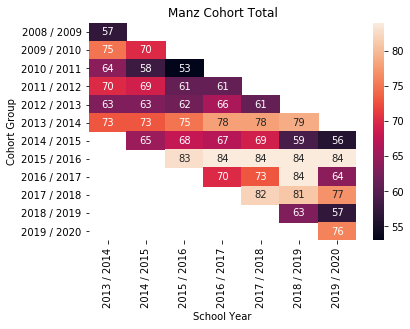

\pagebreak

### Cohort 3 Year Mean

School Year,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,
2010 / 2011,58,,,,
2011 / 2012,66,63,,,
2012 / 2013,62,63,63,,
2013 / 2014,73,75,77,78,
2014 / 2015,,66,68,65,61
2015 / 2016,,,83,84,84
2016 / 2017,,,,75,73
2017 / 2018,,,,,80


\pagebreak

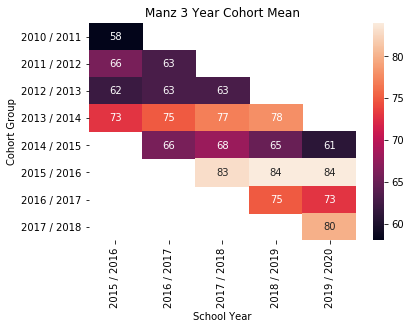

\pagebreak

## Meadowview

### Cohort Total

School Year,2013 / 2014,2014 / 2015,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,,,
2008 / 2009,82,,,,,,
2009 / 2010,57,58,,,,,
2010 / 2011,66,66,73,,,,
2011 / 2012,71,69,78,87,,,
2012 / 2013,78,71,70,79,71,,
2013 / 2014,70,68,80,78,79,74,
2014 / 2015,,79,82,81,76,75,83
2015 / 2016,,,65,75,79,84,76
2016 / 2017,,,,67,71,84,83


\pagebreak

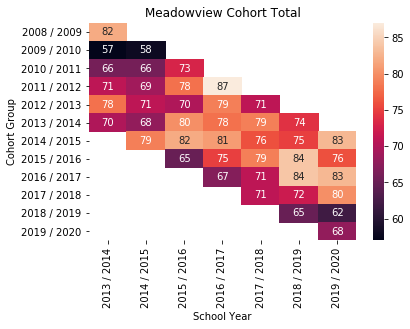

\pagebreak

### Cohort 3 Year Mean

School Year,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,
2010 / 2011,68,,,,
2011 / 2012,72,78,,,
2012 / 2013,73,73,73,,
2013 / 2014,72,75,79,77,
2014 / 2015,,80,79,77,78
2015 / 2016,,,73,79,79
2016 / 2017,,,,74,79
2017 / 2018,,,,,74


\pagebreak

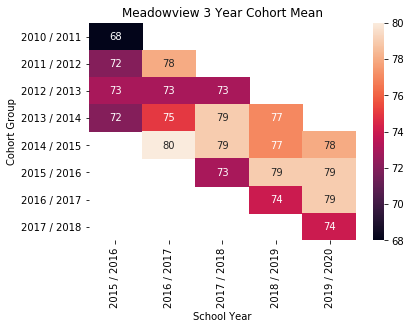

\pagebreak

## Northwoods

### Cohort Total

School Year,2013 / 2014,2014 / 2015,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,,,
2008 / 2009,55,,,,,,
2009 / 2010,55,48,,,,,
2010 / 2011,66,61,59,,,,
2011 / 2012,61,64,65,63,,,
2012 / 2013,80,73,71,67,72,,
2013 / 2014,72,66,67,72,74,73,
2014 / 2015,,62,64,60,58,56,56
2015 / 2016,,,53,55,53,55,51
2016 / 2017,,,,73,61,55,59


\pagebreak

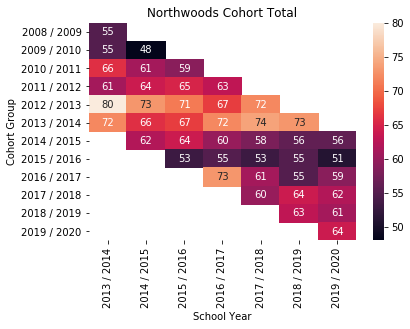

\pagebreak

### Cohort 3 Year Mean

School Year,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,
2010 / 2011,62,,,,
2011 / 2012,63,64,,,
2012 / 2013,74,70,70,,
2013 / 2014,68,68,71,73,
2014 / 2015,,62,60,58,56
2015 / 2016,,,53,54,53
2016 / 2017,,,,63,58
2017 / 2018,,,,,62


\pagebreak

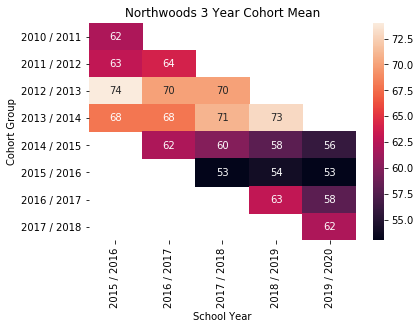

\pagebreak

## Putnam Heights

### Cohort Total

School Year,2013 / 2014,2014 / 2015,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,,,
2008 / 2009,65,,,,,,
2009 / 2010,60,63,,,,,
2010 / 2011,56,61,61,,,,
2011 / 2012,52,59,64,73,,,
2012 / 2013,55,63,73,68,79,,
2013 / 2014,64,71,76,75,82,80,
2014 / 2015,,44,51,53,66,67,70
2015 / 2016,,,72,71,66,71,79
2016 / 2017,,,,69,71,71,69


\pagebreak

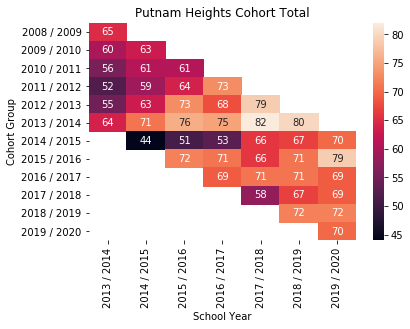

\pagebreak

### Cohort 3 Year Mean

School Year,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,
2010 / 2011,59,,,,
2011 / 2012,58,65,,,
2012 / 2013,63,68,73,,
2013 / 2014,70,74,77,79,
2014 / 2015,,49,56,62,67
2015 / 2016,,,69,69,72
2016 / 2017,,,,70,70
2017 / 2018,,,,,64


\pagebreak

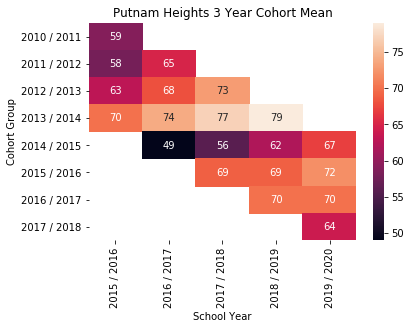

\pagebreak

## Robbins

### Cohort Total

School Year,2013 / 2014,2014 / 2015,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,,,
2008 / 2009,99,,,,,,
2009 / 2010,95,98,,,,,
2010 / 2011,75,87,86,,,,
2011 / 2012,76,75,77,77,,,
2012 / 2013,85,94,96,88,94,,
2013 / 2014,82,87,90,89,92,95,
2014 / 2015,,74,77,84,94,91,86
2015 / 2016,,,69,62,68,74,76
2016 / 2017,,,,84,89,74,89


\pagebreak

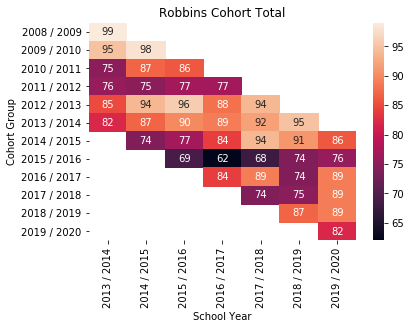

\pagebreak

### Cohort 3 Year Mean

School Year,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,
2010 / 2011,82,,,,
2011 / 2012,76,76,,,
2012 / 2013,91,92,92,,
2013 / 2014,86,88,90,92,
2014 / 2015,,78,85,89,90
2015 / 2016,,,66,68,72
2016 / 2017,,,,82,84
2017 / 2018,,,,,79


\pagebreak

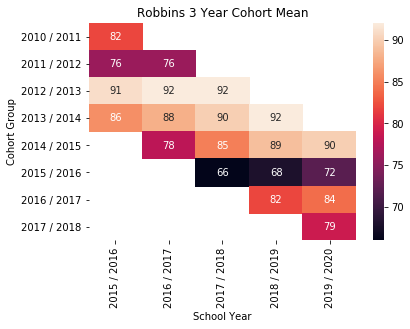

\pagebreak

## Roosevelt

### Cohort Total

School Year,2013 / 2014,2014 / 2015,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,,,
2008 / 2009,41,,,,,,
2009 / 2010,50,52,,,,,
2010 / 2011,44,41,43,,,,
2011 / 2012,44,45,43,42,,,
2012 / 2013,48,55,61,54,53,,
2013 / 2014,56,59,57,55,51,53,
2014 / 2015,,50,53,50,51,48,45
2015 / 2016,,,51,46,46,44,39
2016 / 2017,,,,48,47,44,48


\pagebreak

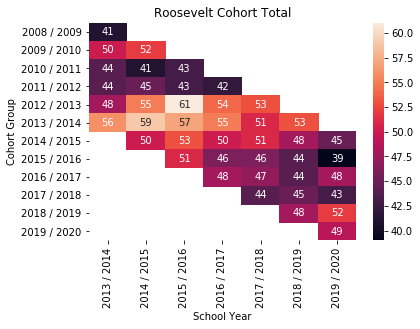

\pagebreak

### Cohort 3 Year Mean

School Year,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,
2010 / 2011,42,,,,
2011 / 2012,44,43,,,
2012 / 2013,54,56,56,,
2013 / 2014,57,57,54,53,
2014 / 2015,,51,51,49,48
2015 / 2016,,,47,45,43
2016 / 2017,,,,46,46
2017 / 2018,,,,,44


\pagebreak

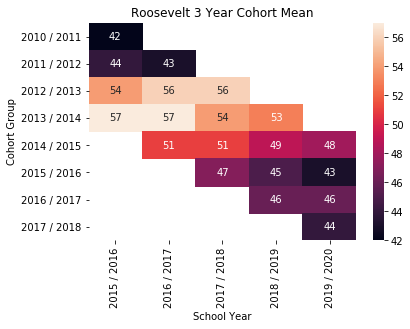

\pagebreak

## Sherman

### Cohort Total

School Year,2013 / 2014,2014 / 2015,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,,,
2008 / 2009,68,,,,,,
2009 / 2010,66,66,,,,,
2010 / 2011,73,80,76,,,,
2011 / 2012,82,77,73,68,,,
2012 / 2013,84,90,83,80,73,,
2013 / 2014,76,73,76,86,85,83,
2014 / 2015,,88,80,80,81,81,76
2015 / 2016,,,78,70,67,65,72
2016 / 2017,,,,91,86,65,89


\pagebreak

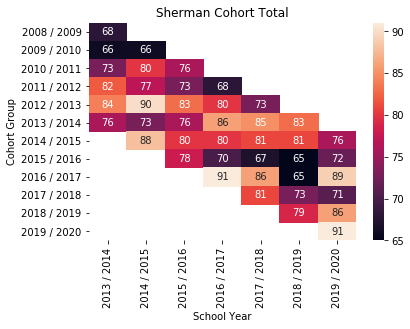

\pagebreak

### Cohort 3 Year Mean

School Year,2015 / 2016,2016 / 2017,2017 / 2018,2018 / 2019,2019 / 2020
Cohort Group,,,,,
2010 / 2011,76,,,,
2011 / 2012,77,72,,,
2012 / 2013,85,84,78,,
2013 / 2014,75,78,82,84,
2014 / 2015,,82,80,80,79
2015 / 2016,,,71,67,68
2016 / 2017,,,,80,80
2017 / 2018,,,,,75


\pagebreak

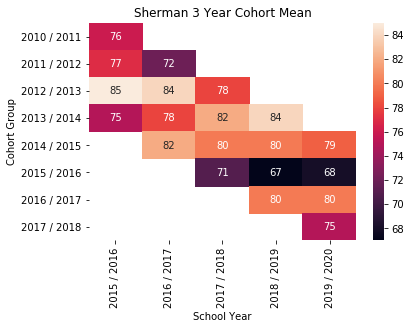

\pagebreak

In [5]:
cohort_group_sum = df.groupby(['Cohort Group','School Year'])['Students'].sum()
cohort_group_sum = cohort_group_sum[cohort_group_sum.notna()].astype('int')

cohort_group_rolling_mean = df.groupby(['Cohort Group','School Year'])['Students'].sum().rolling(3).mean()
cohort_group_rolling_mean = cohort_group_rolling_mean[cohort_group_rolling_mean.notna()].astype('int')

display(Markdown('\pagebreak'))
display(Markdown('## District'))
display(Markdown('### Cohort Total'))
display(cohort_group_sum.unstack(fill_value=''))
display(Markdown('\pagebreak'))

ax = sns.heatmap(cohort_group_sum.unstack(), annot=True, fmt='g')
ax.set_title('District Cohort Total')
plt.show()
display(Markdown('\pagebreak'))

display(Markdown('### Cohort 3 Year Mean'))
display(cohort_group_rolling_mean.unstack(fill_value=''))
display(Markdown('\pagebreak'))

ax = sns.heatmap(cohort_group_rolling_mean.unstack(), annot=True, fmt='g')
ax.set_title('District 3 Year Cohort Mean')
plt.show()
display(Markdown('\pagebreak'))

for school_name, school_df in df.groupby(['School']):
    school_cohort_survival_sum = school_df.groupby(['Cohort Group','School Year'])['Students'].sum()
    school_cohort_survival_sum = school_cohort_survival_sum[school_cohort_survival_sum.notna()].astype('int')
    
    school_cohort_survival_rolling_mean = school_df.groupby(['Cohort Group','School Year'])['Students'].sum().rolling(3).mean()
    school_cohort_survival_rolling_mean = school_cohort_survival_rolling_mean[school_cohort_survival_rolling_mean.notna()].astype('int')
    
    display(Markdown('## {}'.format(school_name)))
    display(Markdown('### Cohort Total'))
    display(school_cohort_survival_sum.unstack(fill_value=''))
    display(Markdown('\pagebreak'))
    
    ax = sns.heatmap(school_cohort_survival_sum.unstack(), annot=True)
    ax.set_title('{} Cohort Total'.format(school_name))
    plt.show()
    display(Markdown('\pagebreak'))
    
    display(Markdown('### Cohort 3 Year Mean'))
    display(school_cohort_survival_rolling_mean.unstack(fill_value=''))
    display(Markdown('\pagebreak'))
    
    ax = sns.heatmap(school_cohort_survival_rolling_mean.unstack(), annot=True)
    ax.set_title('{} 3 Year Cohort Mean'.format(school_name))
    plt.show()
    display(Markdown('\pagebreak'))
    